IMPORT

In [ ]:
import numpy as np
import glob
import sys
import os
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import glob
import math
from scipy.optimize import curve_fit

Input path

In [ ]:
folder = "/home/clowis/cernbox/cern_data/CTR bench analysis/2x2x20bgo/"

names, correction, options

In [ ]:
c_name =       ["F1","F2","F3","F4","F5","F6","F10","F11","F12"]
#int_energy_left_nVs and int_energy_right_nVs have to be included
new_name =     ["max_energy_left_mV",
                "max_energy_right_mV",
                "delta_t_ps",
                "RMS_left_mV",
                "int_energy_left_nVs",
                "int_energy_right_nVs",
                "RMS_right_mV",
                "rise_t_left_ps",
                "rise_t_right_ps"]
corr_factor =  [-1e3,-1e3,1e12,1e3,-1e9,-1e9,1e3,1e12,1e12]
show_plots = True
#photopeak fitting range
up = 665/511
down = 440/511

Combine files

In [ ]:
rm_comb = glob.glob(folder+"*_combined.txt")
for i in range(len(rm_comb)):
    os.remove(rm_comb[i])

first_files = glob.glob(folder+"*00000.txt")
all_files = glob.glob(folder+"*.txt")
other_files = list(set(all_files) - set(first_files))
num = int(len(all_files)/len(first_files))

for i in range(len(first_files)):
    with open(first_files[i][:-9]+"_combined.txt", mode = "w") as comb_txt:
        with open(first_files[i]) as first:
            temp_first = first.readlines() 
            
            for line in range(len(temp_first)-5):
                comb_txt.write(temp_first[line+5])
                
            for j in range(len(other_files)):
                if first_files[i][:-9] == other_files[j][:-9]:
                    with open(other_files[j]) as next:
                        temp_next = next.readlines()
                        for line in range(len(temp_next)-5):
                            comb_txt.write(temp_next[line+5])

transform data in dataframe

In [ ]:
data = pd.DataFrame()
combined_files = glob.glob(folder+"*_combined.txt")
for i in range(len(combined_files)):
    temp = []
    with open(combined_files[i]) as f:
        temp = f.readlines()
        for j in range(len(temp)):
            temp[j] = temp[j][temp[j].find(";")+1:-1]
            name = combined_files[i][combined_files[i].find("/F")+1:combined_files[i].find("V-")-2]
            data[name] = temp

rm_comb = glob.glob(folder+"*_combined.txt")
for i in range(len(rm_comb)):
    os.remove(rm_comb[i])

transform DataFrame str to fload and remove entries with corrupted information

In [ ]:
rows = []
for col in range(len(data.columns)):
    for row in range(len(data)):
        if data.iloc[row,col] == "-1.#IND":
            rows.append(row)

data = data.drop(rows)
data = data.reset_index(drop=True)

for col in range(len(data.columns)):
    for row in range(len(data)):
        data.iloc[row,col] = float(data.iloc[row,col])
        

rename columns and add units

In [ ]:
for i in range(len(c_name)):
    data = data.rename(columns={c_name[i]: new_name[i]})
    data.loc[:,new_name[i]] = data.loc[:,new_name[i]] * corr_factor[i]

Histogramms 

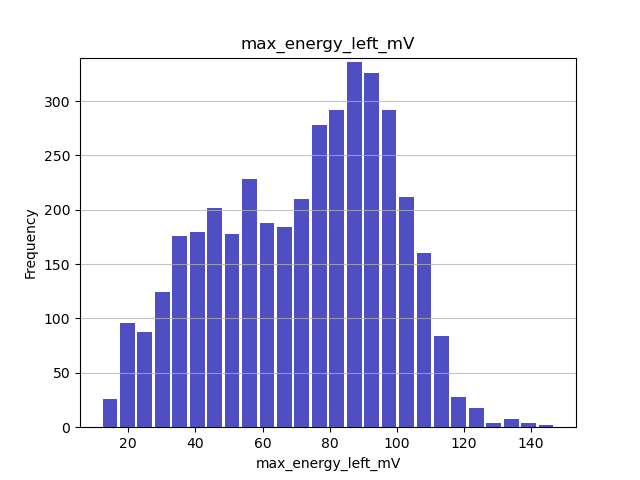

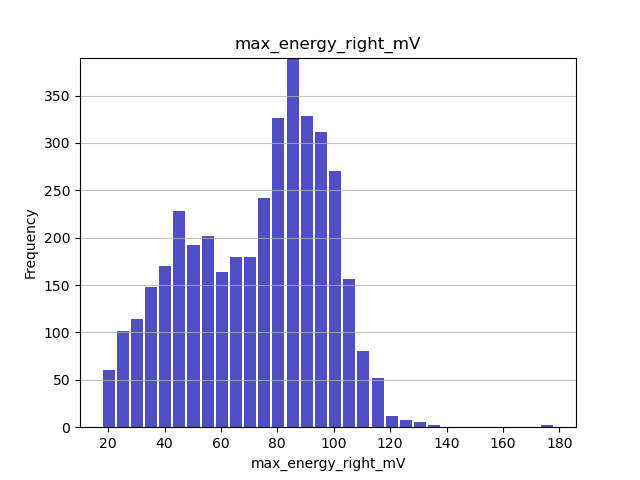

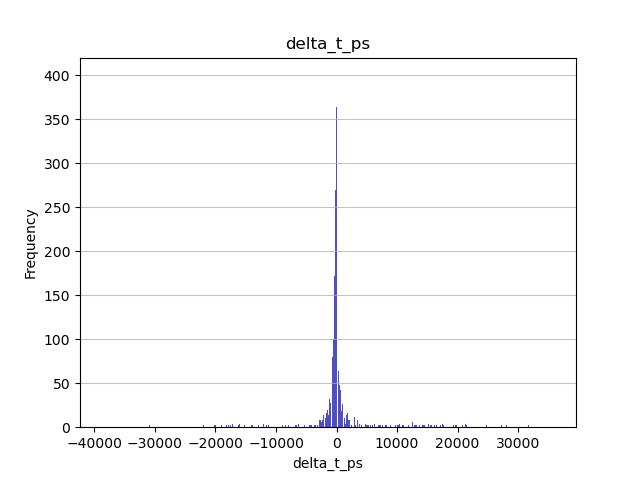

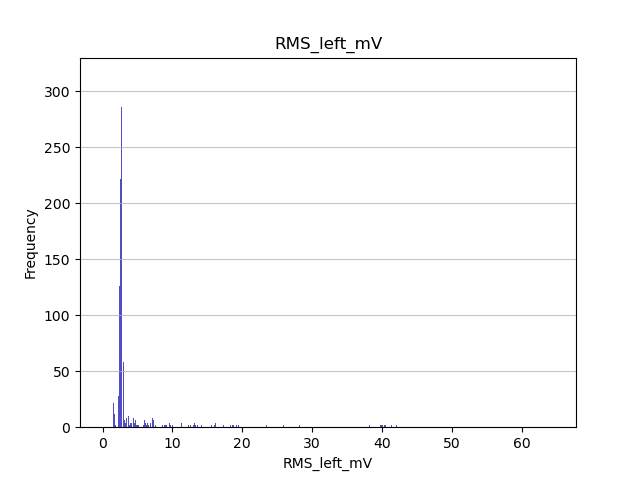

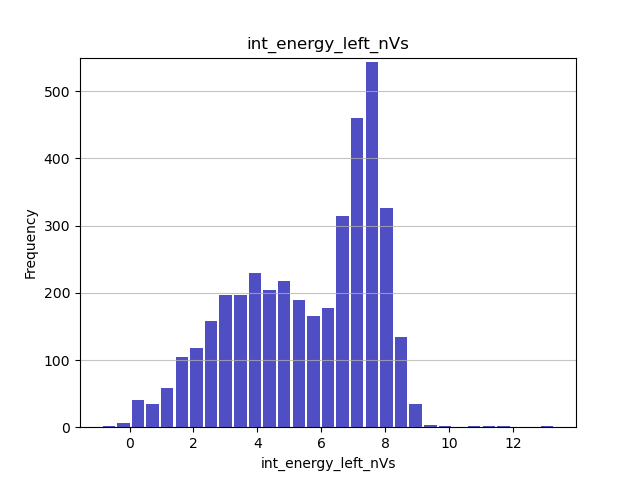

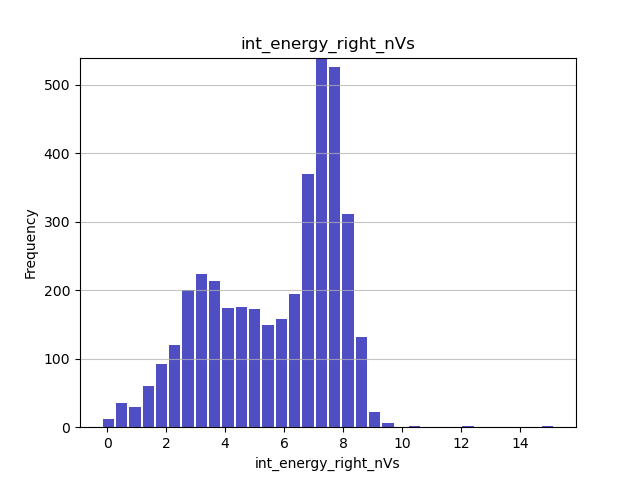

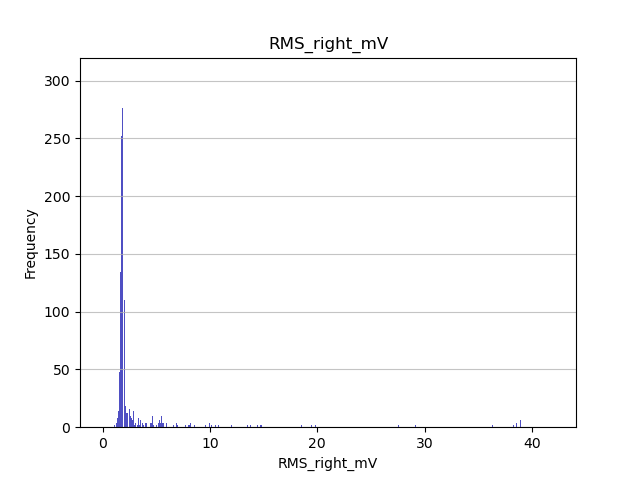

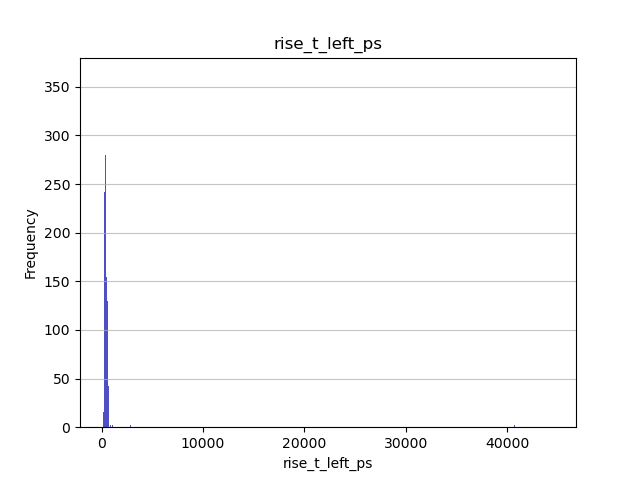

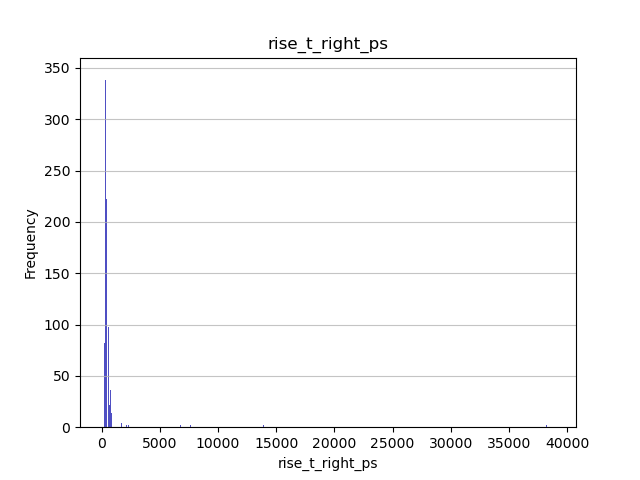

In [ ]:
hist_data = pd.DataFrame()
%matplotlib widget
if show_plots == False:
    print("Plots are off")
    
for i in range(len(new_name)):
    
    x = new_name[i]
    
    q1 = pd.Series(data[x]).quantile(0.25)
    q3 = pd.Series(data[x]).quantile(0.75)
    iqr = q3 - q1
    bin_width = (2 * iqr) / (len(pd.Series(data[x])) ** (1 / 3))
    bin_count = int(np.ceil((pd.Series(data[x]).max() - pd.Series(data[x]).min()) / bin_width))

    x = new_name[i]
    plt.figure(x)
    n, bins, patches = plt.hist(list(data[x]), bins=bin_count, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(x)
    plt.ylabel('Frequency')
    plt.title(x)
    plt.text(23, 45, '')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    additional = pd.DataFrame({str("n_" + x): n})
    hist_data = pd.concat([hist_data, additional], axis=1) 

    patches_list = []
    for j in patches:
        patches_list.append(j.get_x()+j.get_width()/2)
    additional = pd.DataFrame({str("x_" + x): patches_list})
    hist_data = pd.concat([hist_data, additional], axis=1)
    if show_plots == False:
        plt.close()

Energy fit

The fitted Gauss function of the selected photopeak is: 535.4743819940355 * exp(-(x - 7.399058701523754)^2 / (2 * 0.6681860871565607^2)))
a = 535.4743819940355
x0 = 7.399058701523754
sigma = 0.6681860871565607


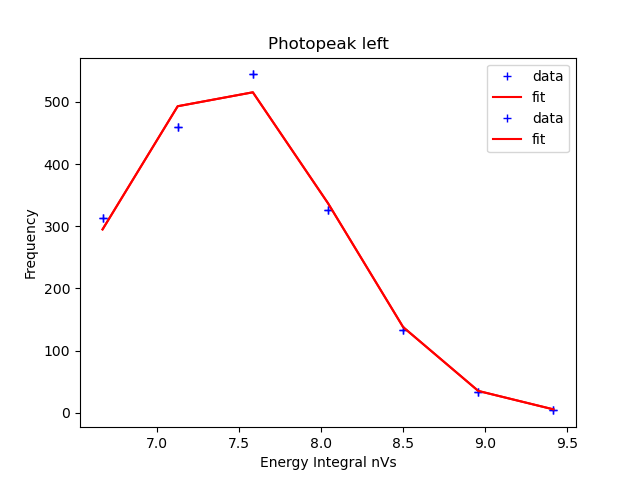

In [32]:
#LEFT
#Gauss fit of the photopeak
#select maximum(photopeak)
#set range around peak for fitting
plt.figure("Photopeak_left")
max_n = np.max(hist_data.n_int_energy_left_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_left_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_left_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_left_nVs==lower_x].index.values)
# gauss fit
x = np.array(hist_data.x_int_energy_left_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[lower_ind:upper_ind])

mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt_gauss_left,pcov = curve_fit(Gauss, x, y, p0=[np.max(y), mean, sigma])

print("The fitted Gauss function of the selected photopeak is: " + str(popt_gauss_left[0]) + " * exp(-(x - " + str(popt_gauss_left[1]) + ")^2 / (2 * " + str(popt_gauss_left[2]) + "^2)))")
print("a =",popt_gauss_left[0])
print("x0 =",popt_gauss_left[1])
print("sigma =",popt_gauss_left[2])

if show_plots == True:
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x, Gauss(x, *popt_gauss_left), 'r-', label='fit')
    plt.legend()
    plt.title('Photopeak left')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

The fitted Compton function of the selected Compton area is: 215.252488347244 / sqrt( 1 + (x / 6.652229712151028)^ 6.501518700957132
a = 215.252488347244
b = 6.652229712151028
c = 6.501518700957132


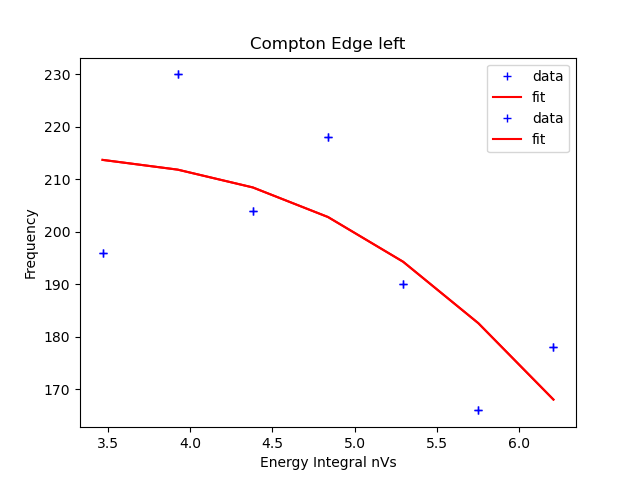

In [33]:
#fit compton
plt.figure("Compton_left")
c_max_n = np.max(hist_data.n_int_energy_left_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)
c_upper_ind = int(lower_ind * 1)

x = np.array(hist_data.x_int_energy_left_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[c_lower_ind:c_upper_ind])

a = np.max(y)
b = hist_data.x_int_energy_left_nVs[int(c_upper_ind*0.9)]
c = 5

def Compton(x, a, b, c):
    return a / np.sqrt(1 + np.power((x / np.abs(b)), c))

popt_comp_left,pcov = curve_fit(Compton, x, y , p0=[a, b, c])

print("The fitted Compton function of the selected Compton area is: " + str(popt_comp_left[0]) + " / sqrt( 1 + (x / " + str(popt_comp_left[1]) + ")^ " + str(popt_comp_left[2]))
print("a =",popt_comp_left[0])
print("b =",popt_comp_left[1])
print("c =",popt_comp_left[2])

if show_plots == True:
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x, Compton(x, *popt_comp_left), 'r-', label='fit')
    plt.legend()
    plt.title('Compton Edge left')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

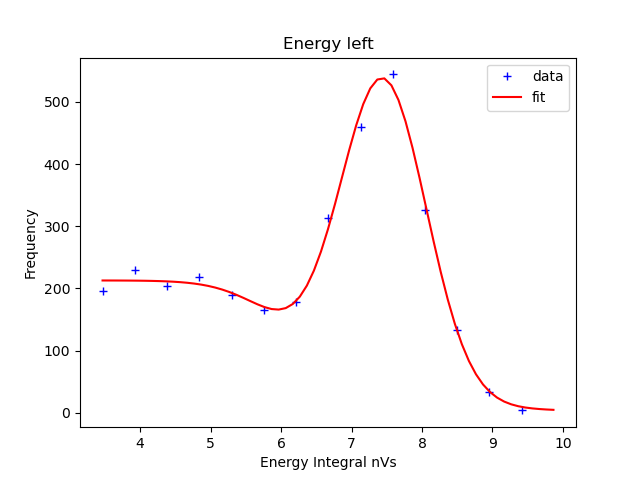

In [34]:
#Energy fit
def Energy_fit(x, a, b, c, d, e, f):
    return a / np.sqrt(1 + np.power((x / np.abs(b)), c)) + d * np.exp(-(x - e)**2 / (2 * f**2))

plt.figure("Energy_left")
max_n = np.max(hist_data.n_int_energy_left_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_left_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_left_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_left_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_left_nVs==lower_x].index.values)
c_max_n = np.max(hist_data.n_int_energy_left_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_left_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)

#quess values
x = np.array(hist_data.x_int_energy_left_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[lower_ind:upper_ind])
a = np.max(y)
b = sum(x * y) / sum(y)
c = np.sqrt(sum(y * (x - mean)**2) / sum(y))
x = np.array(hist_data.x_int_energy_left_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[c_lower_ind:c_upper_ind])
d = np.max(y)
e = hist_data.x_int_energy_left_nVs[int(c_upper_ind)]
f = 1
x = np.array(hist_data.x_int_energy_left_nVs[c_lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_left_nVs[c_lower_ind:upper_ind])
x_fit_left = np.arange(hist_data.x_int_energy_left_nVs[c_lower_ind],hist_data.x_int_energy_left_nVs[upper_ind],0.1)

popt_left,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_left = Energy_fit(x_fit_left, *popt_left)

if show_plots == True:
    plt.close()
    plt.figure("Energy fit left")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_left, Energy_fit(x_fit_left, *popt_left), 'r-', label='fit')
    plt.legend()
    plt.title('Energy left')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

The fitted Gauss function of the selected photopeak is: 558.2858727740138 * exp(-(x - 7.422104449105027)^2 / (2 * 0.7012757251875514^2)))
a = 558.2858727740138
x0 = 7.422104449105027
sigma = 0.7012757251875514


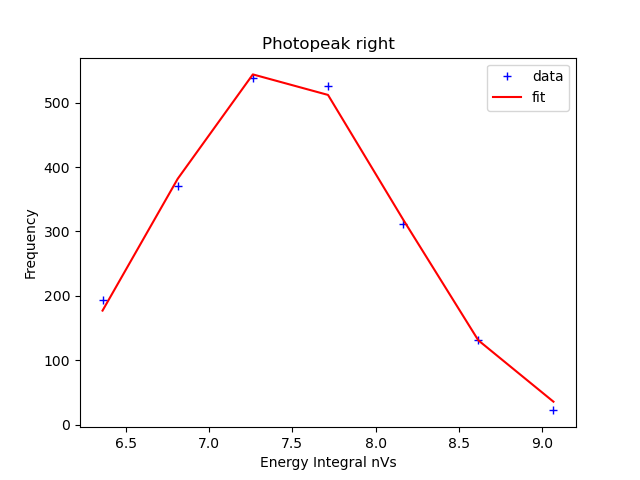

In [ ]:
#RIGHT
#Gauss fit of the photopeak
#select maximum(photopeak)
#set range around peak for fitting
plt.figure("Photopeak_right")
max_n = np.max(hist_data.n_int_energy_right_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_right_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_right_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_right_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_right_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_right_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_right_nVs==lower_x].index.values)
# gauss fit
x = np.array(hist_data.x_int_energy_right_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[lower_ind:upper_ind])

mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt_gauss_right,pcov = curve_fit(Gauss, x, y, p0=[np.max(y), mean, sigma])

print("The fitted Gauss function of the selected photopeak is: " + str(popt_gauss_right[0]) + " * exp(-(x - " + str(popt_gauss_right[1]) + ")^2 / (2 * " + str(popt_gauss_right[2]) + "^2)))")
print("a =",popt_gauss_right[0])
print("x0 =",popt_gauss_right[1])
print("sigma =",popt_gauss_right[2])

if show_plots == True:
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x, Gauss(x, *popt_gauss_right), 'r-', label='fit')
    plt.legend()
    plt.title('Photopeak right')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

The fitted Compton function of the selected Compton area is: 228.13138647261968 / sqrt( 1 + (x / 5.355883717093448)^ 3.034166908426944
a = 228.13138647261968
b = 5.355883717093448
c = 3.034166908426944


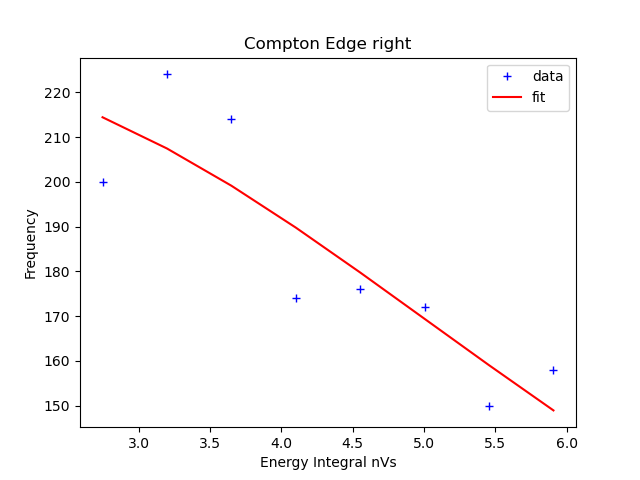

In [ ]:
#fit compton
plt.figure("Compton_right")
c_max_n = np.max(hist_data.n_int_energy_right_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_right_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)
c_upper_ind = int(lower_ind * 1)

x = np.array(hist_data.x_int_energy_right_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[c_lower_ind:c_upper_ind])

a = np.max(y)
b = hist_data.x_int_energy_right_nVs[int(c_upper_ind*0.9)]
c = 5

def Compton(x, a, b, c):
    return a / np.sqrt(1 + np.power((x / np.abs(b)), c))

popt_comp_right,pcov = curve_fit(Compton, x, y , p0=[a, b, c])

print("The fitted Compton function of the selected Compton area is: " + str(popt_comp_right[0]) + " / sqrt( 1 + (x / " + str(popt_comp_right[1]) + ")^ " + str(popt_comp_right[2]))
print("a =",popt_comp_right[0])
print("b =",popt_comp_right[1])
print("c =",popt_comp_right[2])

if show_plots == True:
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x, Compton(x, *popt_comp_right), 'r-', label='fit')
    plt.legend()
    plt.title('Compton Edge right')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

NameError: name 'mean' is not defined

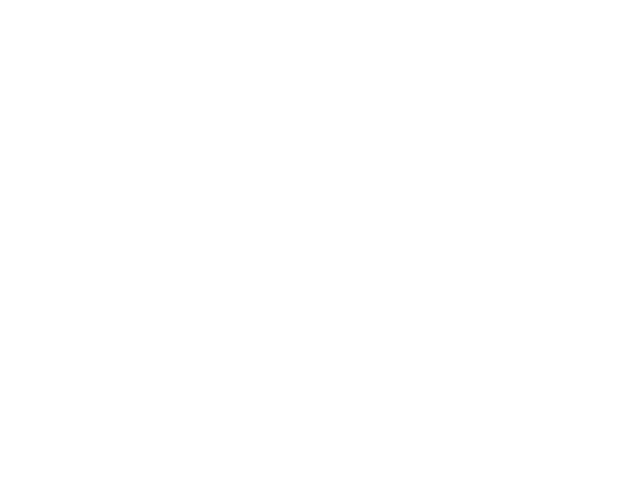

In [26]:
#Energy fit

plt.figure("Energy_right")
max_n = np.max(hist_data.n_int_energy_right_nVs)
max_ind = int(hist_data[hist_data.n_int_energy_right_nVs==max_n].index.values)
max_x = hist_data.x_int_energy_right_nVs[max_ind]
upper_x = min(hist_data.x_int_energy_right_nVs, key=lambda x:abs(x-max_x*up))
lower_x = min(hist_data.x_int_energy_right_nVs, key=lambda x:abs(x-max_x*down))
upper_ind = int(hist_data[hist_data.x_int_energy_right_nVs==upper_x].index.values)
lower_ind = int(hist_data[hist_data.x_int_energy_right_nVs==lower_x].index.values)
c_max_n = np.max(hist_data.n_int_energy_right_nVs[:lower_ind])
c_max_ind = int(hist_data[hist_data.n_int_energy_right_nVs==c_max_n].index.values)
c_lower_ind = int(c_max_ind * 0.9)

#quess values
x = np.array(hist_data.x_int_energy_right_nVs[lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[lower_ind:upper_ind])
a = np.max(y)
b = sum(x * y) / sum(y)
c = np.sqrt(sum(y * (x - mean)**2) / sum(y))
x = np.array(hist_data.x_int_energy_right_nVs[c_lower_ind:c_upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[c_lower_ind:c_upper_ind])
d = np.max(y)
e = hist_data.x_int_energy_right_nVs[int(c_upper_ind)]
f = 1
x = np.array(hist_data.x_int_energy_right_nVs[c_lower_ind:upper_ind])
y = np.array(hist_data.n_int_energy_right_nVs[c_lower_ind:upper_ind])
x_fit_right = np.arange(hist_data.x_int_energy_right_nVs[c_lower_ind],hist_data.x_int_energy_right_nVs[upper_ind],0.1)

popt_right,pcov = curve_fit(Energy_fit, x, y, p0=[a,b,c,d,e,f])
y_fit_right = Energy_fit(x_fit_right, *popt_right)

if show_plots == True:
    plt.close()
    plt.figure("Energy fit right")
    plt.plot(x, y, 'b+', label='data')
    plt.plot(x_fit_right, Energy_fit(x_fit_right, *popt_right), 'r-', label='fit')
    plt.legend()
    plt.title('Energy right')
    plt.xlabel('Energy Integral nVs')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Plots are off")

Cut for 511 keV events

In [ ]:
cut_data = data
down = 0.95
up = 1.05
energy1_left = x_fit_left[list(y_fit_left).index(max(list(y_fit_left)))] * down
energy2_left = x_fit_left[list(y_fit_left).index(max(list(y_fit_left)))] * up
energy1_right= x_fit_right[list(y_fit_right).index(max(list(y_fit_right)))] * down
energy2_right= x_fit_right[list(y_fit_right).index(max(list(y_fit_right)))] * up

for i in range(len(cut_data)):
    left = cut_data.int_energy_left_nVs[i]
    right = cut_data.int_energy_right_nVs[i]
    if left < energy1_left or left > energy2_left or right < energy1_right or right > energy2_right:
        cut_data = cut_data.drop([i])



In [ ]:
np.std(cut_data.delta_t_ps)
len(cut_data)

In [ ]:
hist_data = pd.DataFrame()
%matplotlib widget
if show_plots == False:
    print("Plots are off")
    
for i in range(len(new_name)):
    
    x = new_name[i]
    
    q1 = pd.Series(cut_data[x]).quantile(0.25)
    q3 = pd.Series(cut_data[x]).quantile(0.75)
    iqr = q3 - q1
    bin_width = (2 * iqr) / (len(pd.Series(cut_data[x])) ** (1 / 3))
    bin_count = int(np.ceil((pd.Series(cut_data[x]).max() - pd.Series(cut_data[x]).min()) / bin_width))

    x = new_name[i]
    plt.figure(x)
    n, bins, patches = plt.hist(list(cut_data[x]), bins=bin_count, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(x)
    plt.ylabel('Frequency')
    plt.title(x)
    plt.text(23, 45, '')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    additional = pd.DataFrame({str("n_" + x): n})
    hist_data = pd.concat([hist_data, additional], axis=1) 

    patches_list = []
    for j in patches:
        patches_list.append(j.get_x()+j.get_width()/2)
    additional = pd.DataFrame({str("x_" + x): patches_list})
    hist_data = pd.concat([hist_data, additional], axis=1)
    if show_plots == False:
        plt.close()

In [ ]:
len(data)

3924

In [ ]:
len(drop)

NameError: name 'drop' is not defined

In [ ]:
data.int_energy_left_nVs[0]